## 1. Problem Framing

The goal of this project is to develop an image classification model that can accurately predict the name of Cricketers from images uploaded to a website. The dataset contains images of Nepalese cricketers, and the task is to classify each image into one of the predefined categories.

To achieve this, we will follow a series of steps such as data preprocessing, data cleaning, and data exploration to prepare the data for modeling. We will then perform feature engineering to extract relevant features from the images and select the best model and hyperparameters to train the classification model.

Once the model is trained, we will evaluate its performance on a test dataset and fine-tune it as necessary. Finally, we will integrate the model into a web application, allowing users to upload images to the website and receive predictions about the Nepalese cricketer in the image.

The success of this project will be determined by the accuracy and efficiency of the model in classifying the images, as well as the smooth and user-friendly interface of the web application

## 2. Data Aquisition
To acquire the necessary data for my image classification project, I performed web scraping of Cricketers images from Google. I achieved this by utilizing a [Python script](data_aquisition/web_scrapping.py) that implements web scraping techniques to download images of Cristiano Ronaldo from Google. The script imports essential libraries such as requests, os, time, and BeautifulSoup.

To begin, the search query and the desired number of images to download are defined, along with the URL of the search results page. The script then executes a GET request to the URL, obtains the HTML content using the requests library, and parses the content with the BeautifulSoup library to locate all image tags.

In case a folder with the search query's name does not already exist, the script uses the os.mkdir() function to create a new folder. The script proceeds to iterate through the image tags and downloads each image to the folder using the with open() statement. To prevent Google from blocking further requests, the script introduces a delay of 10 seconds between each 20 requests using the time.sleep() function.

## 3. Data Preprocessing and Cleaning

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [9]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [10]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [11]:
path_data = "./dataset/"
path_cropped_data = "./dataset/cropped/"

In [12]:
import os
img_dirs = [file.path for file in os.scandir(path_data) if file.is_dir()]

In [13]:
import shutil
if os.path.exists(path_cropped_data):
     shutil.rmtree(path_cropped_data)
os.mkdir(path_cropped_data)

In [14]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_cropped_data+ celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1 

Rohit_Sharma
Generating cropped images in folder:  ./dataset/cropped/Rohit_Sharma
Ab_De_Villiers
Generating cropped images in folder:  ./dataset/cropped/Ab_De_Villiers
MS_Dhoni
Generating cropped images in folder:  ./dataset/cropped/MS_Dhoni
Sachin_Tendulkar
Generating cropped images in folder:  ./dataset/cropped/Sachin_Tendulkar


libpng warning: iCCP: known incorrect sRGB profile


Virat_Kholi
Generating cropped images in folder:  ./dataset/cropped/Virat_Kholi
cropped


In [43]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

## 4. Feature Engineering

In [44]:
def w2d(imArray, mode='haar', level=1):
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)   
    imArray /= 255
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [45]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1

In [46]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None or img.size == 0:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [47]:
X = np.array(X).astype(float)
y = np.array(y).astype(float)
X.shape

(183, 4096, 1)

In [48]:
X = X.reshape(X.shape[0], 4096)
X.shape

(183, 4096)

## 5. Model Selection

In [49]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [50]:
import tensorflow as tf
from tensorflow import keras

neural_network = keras.Sequential([
    keras.layers.Reshape((64, 64, 1), input_shape=X.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(y), activation='softmax')
])

neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
neural_network.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20
6/6 [==============================] - 0s 4ms/step - loss: 442.8880 - accuracy: 0.0656
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 130.7166 - accuracy: 0.3115
Epoch 3/20
6/6 [==============================] - 0s 6ms/step - loss: 110.1659 - accuracy: 0.3661
Epoch 4/20
6/6 [==============================] - 0s 4ms/step - loss: 66.8273 - accuracy: 0.4536
Epoch 5/20
6/6 [==============================] - 0s 4ms/step - loss: 44.5848 - accuracy: 0.4863
Epoch 6/20
6/6 [==============================] - 0s 5ms/step - loss: 26.4301 - accuracy: 0.5847
Epoch 7/20
6/6 [==============================] - 0s 5ms/step - loss: 20.5518 - accuracy: 0.6120
Epoch 8/20
6/6 [==============================] - 0s 5ms/step - loss: 13.1054 - accuracy: 0.6995
Epoch 9/20
6/6 [==============================] - 0s 4ms/step - loss: 6.8457 - accuracy: 0.8087
Epoch 10/20
6/6 [==============================] - 0s 4ms/step - loss: 2.4468 - accuracy: 0.8907
Epoch 11/20
6/6 [===========

In [51]:
neural_network.evaluate(X, y)

6/6 [==============================] - 0s 2ms/step - loss: 2.1497e-08 - accuracy: 1.0000


[2.1496740387760838e-08, 1.0]

In [52]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        },
    }
    }

In [53]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.754204,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.590240,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.716517,{'logisticregression__C': 1}


## 7. Model Training

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=True)

In [27]:
neural_network = keras.Sequential([
    keras.layers.Reshape((64, 64, 1), input_shape=X.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(y), activation='softmax')
])

neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
neural_network.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
7/7 [==============================] - 0s 3ms/step - loss: 206.5740 - accuracy: 0.0863
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 250.1349 - accuracy: 0.2690
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 132.6774 - accuracy: 0.2690
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 97.3708 - accuracy: 0.3909
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 83.9178 - accuracy: 0.4822
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 45.8645 - accuracy: 0.5076
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 40.0340 - accuracy: 0.4772
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 23.7615 - accuracy: 0.5990
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 13.5391 - accuracy: 0.6650
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 23.8484 - accuracy: 0.6447
Epoch 11/20
7/7 [=========

## 8. Model Evaluation

In [28]:
neural_network.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 23.5630 - accuracy: 0.4242


[23.563024520874023, 0.42424243688583374]

In [41]:
from sklearn.metrics import confusion_matrix
y_pred = neural_network(X_test)
cm = confusion_matrix(y_test, tf.argmax(y_pred, axis=1))

Text(95.72222222222221, 0.5, 'Truth')

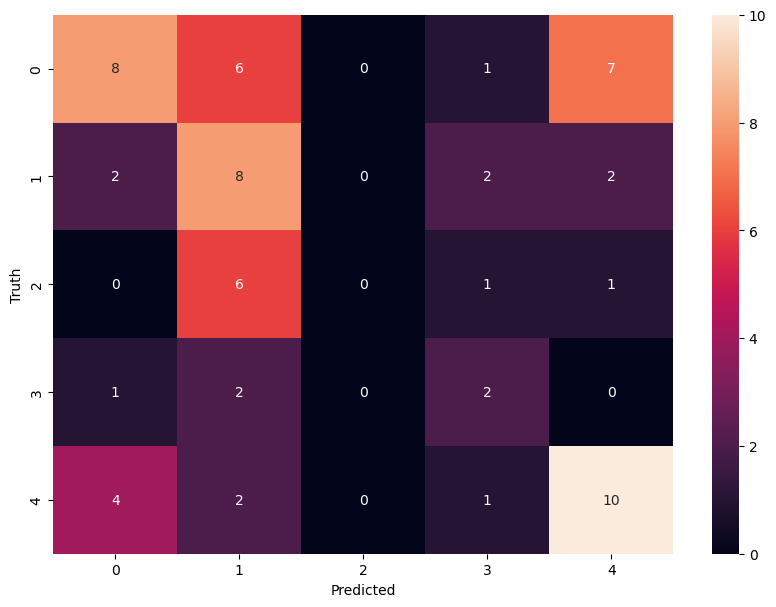

In [42]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [1]:
import joblib 
joblib.dump(neural_network, 'saved_model.pkl')

NameError: name 'neural_network' is not defined

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

## 9. Model Deployment

## 10. Monitoring and Deployment